In [1]:
from model import *
from data import *

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"


data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'../input/train/','images','masks',data_gen_args,save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=100,callbacks=[model_checkpoint])

#testGene = testGenerator("data/membrane/test")
#results = model.predict_generator(testGene,30,verbose=1)
#saveResult("data/membrane/test",results)

Using TensorFlow backend.
/home/ubuntu/unet/model.py:97: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Epoch 1/100
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
300/300 [==============================] - 148s 495ms/step - loss: 0.4994 - acc: 0.7714

Epoch 00001: loss improved from inf to 0.49939, saving model to unet_membrane.hdf5
Epoch 2/100
300/300 [==============================] - 112s 374ms/step - loss: 0.4240 - acc: 0.8216

Epoch 00002: loss improved from 0.49939 to 0.42400, saving model to unet_membrane.hdf5
Epoch 3/100
300/300 [==============================] - 112s 375ms/step - loss: 0.3818 - acc: 0.8445

Epoch 00003: loss improved from 0.42400 to 0.38176, saving model to unet_membrane.hdf5
Epoch 4/100
300/300 [==============================] - 112s 375ms/step - loss: 0.3418 - acc: 0.8656

Epoch 00004: loss improved from 0.38176 to 0.34181, saving model to unet_membrane.hdf5
Epoch 5/100
300/300 [==============================] - 113s 375ms/step - loss: 0.3404 - acc: 0.8691

Epoch 00005: loss improved from 0.34181 to 0.34045, saving model to

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
cd ..

/home/ubuntu


In [11]:
!mkdir weight_and_model

In [14]:
cd unet

/home/ubuntu/unet


In [15]:
# モデルを保存
print("Model saving... at ./drive/My Drive/model.json")
from keras.utils import plot_model
model_json = model.to_json()
with open("../weight_and_model/model", mode='w') as f:
    f.write(model_json)

# 学習済みの重みを保存
print("Weight saving... at ./drive/My Drive/weights.hdf5")
model.save_weights("../weight_and_model/weights.hdf5")

Model saving... at ./drive/My Drive/model.json
Weight saving... at ./drive/My Drive/weights.hdf5


In [20]:
from PIL import Image
img = Image.open('../input/train/images/01b5362cce.png')
img = img.convert('L')
img = img.resize((256,256))
img = np.array(img)
img = img /255
img = img.reshape(1,256,256,1)
print(img.shape)

(1, 256, 256, 1)


In [21]:
results = model.predict(img)

In [22]:
from keras import preprocessing

In [23]:
pred_img = preprocessing.image.array_to_img(results[0])

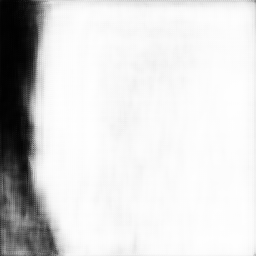

In [24]:
pred_img

In [27]:
img = Image.open('../input/train/masks/01b5362cce.png')

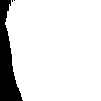

In [28]:
img

また、main.pyではBatchNormalizationを行っていないので追加し、upsamplingもtransposed_convlutionに変更して同様に学習させてみた
BatchNormalizationを行うときは活性化関数を適用する前にBatchNormalizationを入れたいので、2DConvのときにactivationを指定しない
精度はほとんど変わらなかった.若干見た目でカスタムしない方がいいように思えるのでよりよい方法を見つけたい

【問題2】コードリーディング

Unetは収縮パスと拡張パスが重要である
実現しているのはmodel.pyである
kerasを使っていて


収縮パスは

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)

conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

で二回の畳み込みを行い、

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

でpoolingを行うまでが1ブロックの流れ。

拡張パスは

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

でupconvして

merge6 = concatenate([drop4,up6], axis = 3)

でスキップ接続とチャンネル方向に結合し、

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

の二回の畳み込みを行いblockが終了する.最後の層で

conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
のようにsoftmaxした後出力する

lossは'binary_crossentropy'でOptimizerはAdam, metricsはacccuracy

原著論文では境界付近のlossが大きくなるように重みづけされているが今回は普通のbinary_crossentropyを使用している